In [1]:
#Basics 
import numpy as np
import pandas as pd 
import math, random
import sys, os 
import sklearn
from sklearn.metrics import balanced_accuracy_score, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from scipy import stats 
import scipy
import matplotlib 
import matplotlib.pyplot as plt 
from glob import glob
from itertools import cycle
%matplotlib inline

#Google Drive setup 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Navigate to directory with Google Drive
%cd /content/drive/Shareddrives/CS\ 272\ PCOS\ FL/Model\ Evaluation/

/content/drive/Shareddrives/CS 272 PCOS FL/Model Evaluation


In [3]:
#Load in the noise/masking vectors 
clinic_hormone_percent_noise = np.load('clinic_hormone_noise_levels_noise_challenge.npy')
clinic_symptom_mask_prob = np.load('clinic_symptom_mask_levels_noise_challenge.npy')

In [4]:
# !unzip true_test_clinics/baseline_aggr_logreg/Archive.zip -d true_test_clinics/baseline_aggr_logreg/

In [5]:
# #preprocess real test clinic data 
# for i in range(10):
#   clinic = pd.read_csv(f'../Synthetic Data Generation /clinic_datasets_sophie_hormone_generation/clinic_{i+15}.csv')
#   clinic['response_type'] = clinic.response_type.values - 1
#   clinic['treatment'] = clinic.treatment.values - 1
#   preds = np.load(f'true_test_clinics/baseline_aggr_logreg/clinic_{i+15}_preds.npy')
#   pred_treatment = np.argmax(preds, axis=1)
#   clinic['pred_treatment'] = pred_treatment
#   clinic[[f'{j}_prob' for j in range(10)]] = preds
#   clinic.to_csv(f'true_test_clinics/baseline_aggr_logreg/test_clinic_{i}.csv', index=False)

In [6]:
# !sudo rm true_test_clinics/baseline_aggr_logreg/*.npy

In [7]:
FL_methods = {}
for clinic_files in glob('noise_challenge_test_clinics/*'):
#Load in test set clinics with predictions 
  if 'MLP' in clinic_files:
    continue
  method_name = clinic_files.split('/')[-1]
  clinics = {}
  for i in range(10):
    clinics[i] = pd.read_csv(f'{clinic_files}/test_clinic_{i}.csv') #add index=0 as necessary to avoid "Unnamed: 0" column from appearing
  FL_methods[method_name] = clinics 

In [8]:
FL_methods.keys()

dict_keys(['FedAvg', 'FedAvgM', 'Baseline Aggregate Model', 'FedProx'])

In [9]:
method_specific_full_patient_dfs = {}
method_specific_per_clinic_accuracies = []

for method in ['FedAvg', 'FedAvgM', 'FedProx', 'Baseline Aggregate Model']:
  all_patients = None
  per_clinic_accuracies = []
  for i, clinic in FL_methods[method].items():
    per_clinic_accuracies.append(balanced_accuracy_score(clinic.treatment.values, clinic.pred_treatment.values))
    if all_patients is None:
      all_patients = clinic
    else:
      all_patients = pd.concat([all_patients, clinic], ignore_index=True)
  method_specific_full_patient_dfs[method] = all_patients
  method_specific_per_clinic_accuracies.append(per_clinic_accuracies)

method_specific_per_clinic_accuracies = np.array(method_specific_per_clinic_accuracies)

In [10]:
label_binarizer = LabelBinarizer().fit(np.arange(10))
true_y = None
all_patient_yscores = []
for method in ['FedAvg', 'FedAvgM', 'FedProx', 'Baseline Aggregate Model']:
  print(method)
  df = method_specific_full_patient_dfs[method]
  if true_y is None:
    true_y = label_binarizer.transform(df.treatment.values)
  
  all_patient_yscores.append(df[[f'{i}_prob' for i in range(10)]].to_numpy())

FedAvg
FedAvgM
FedProx
Baseline Aggregate Model


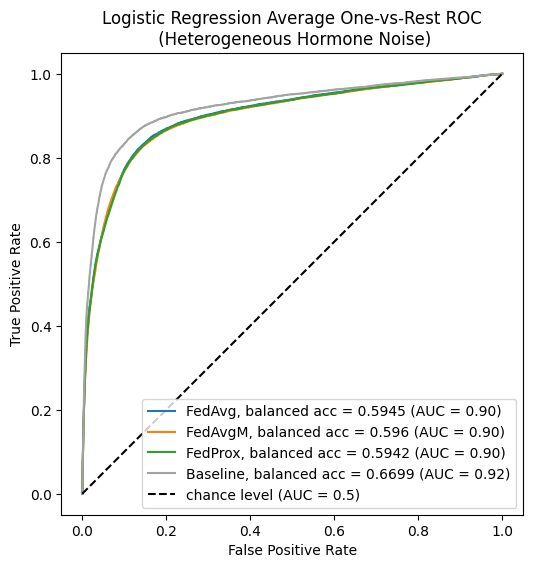

In [11]:
#Plot ROC
# RocCurveDisplay.from_predictions(
#     y_onehot_test.ravel(),
#     y_score.ravel(),
#     name="micro-average OvR",
#     color="darkorange",
# )

fig, ax = plt.subplots(figsize=(6, 6))

#colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for method, y_score in zip(['FedAvg', 'FedAvgM', 'FedProx'], all_patient_yscores):
    RocCurveDisplay.from_predictions(
        true_y.ravel(),
        y_score.ravel(),
        name=f"{method}, balanced acc = {np.round(balanced_accuracy_score(method_specific_full_patient_dfs[method].treatment.values, method_specific_full_patient_dfs[method].pred_treatment.values), 4)}",
        #color=color,
        ax=ax,
    )
RocCurveDisplay.from_predictions(
    true_y.ravel(),
    all_patient_yscores[3].ravel(),
    name=f"Baseline, balanced acc = {np.round(balanced_accuracy_score(method_specific_full_patient_dfs['Baseline Aggregate Model'].treatment.values, method_specific_full_patient_dfs['Baseline Aggregate Model'].pred_treatment.values), 4)}",
    color='#a3a3a3',
    ax=ax,
)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression Average One-vs-Rest ROC\n (Heterogeneous Hormone Noise)")
plt.legend()
plt.show()

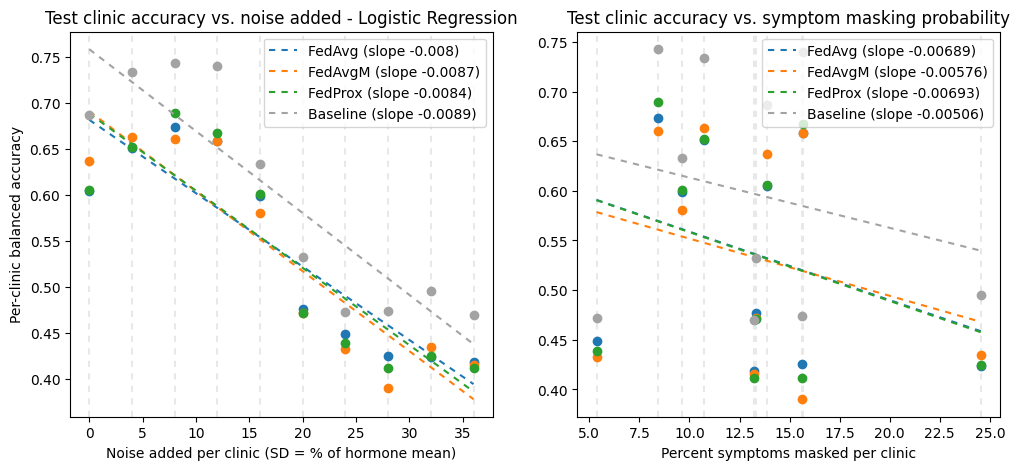

In [14]:
#test out plot of clinic accuracy vs noise
#Expect to see lines of negative slope
fig, ax = plt.subplots(1,2, figsize=(12,5))
methods = ['FedAvg', 'FedAvgM', 'FedProx']#, 'Baseline Aggregate Model']

#Show the accuracies per FL method and their lines of best fit 
for i in range(method_specific_per_clinic_accuracies.shape[0]-1):
  x1 = clinic_hormone_percent_noise.squeeze()
  y1 = np.array(method_specific_per_clinic_accuracies[i]).squeeze()
  x2 = clinic_symptom_mask_prob.squeeze()
  y2 = np.array(method_specific_per_clinic_accuracies[i]).squeeze()
  ax[0].scatter(x1, y1, zorder=2)
  ax[0].plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)), label=f'{methods[i]} (slope {np.round(np.polyfit(x1, y1, 1)[0], 4)})', dashes=(3,3))
  ax[1].scatter(x2, y2, zorder=2)
  ax[1].plot(np.unique(x2), np.poly1d(np.polyfit(x2, y2, 1))(np.unique(x2)), label=f'{methods[i]} (slope {np.round(np.polyfit(x2, y2, 1)[0], 5)})', dashes=(3,3))

x1 = clinic_hormone_percent_noise.squeeze()
y1 = np.array(method_specific_per_clinic_accuracies[-1]).squeeze()
x2 = clinic_symptom_mask_prob.squeeze()
y2 = np.array(method_specific_per_clinic_accuracies[-1]).squeeze()
ax[0].scatter(x1, y1, zorder=2, color="#a3a3a3")
ax[0].plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)), label=f'Baseline (slope {np.round(np.polyfit(x1, y1, 1)[0], 4)})', dashes=(3,3), color="#a3a3a3")
ax[1].scatter(x2, y2, zorder=2, color="#a3a3a3")
ax[1].plot(np.unique(x2), np.poly1d(np.polyfit(x2, y2, 1))(np.unique(x2)), label=f'Baseline (slope {np.round(np.polyfit(x2, y2, 1)[0], 5)})', dashes=(3,3), color="#a3a3a3")

#Show the clinics and their noise 
for i in range(10):
  ax[0].axvline(x = clinic_hormone_percent_noise[i], color = '#e8e8e8', dashes = (3, 3), zorder=1)
  ax[1].axvline(x = clinic_symptom_mask_prob[i], color = '#e8e8e8', dashes = (3,3), zorder=1)

ax[0].set_xlabel("Noise added per clinic (SD = % of hormone mean)")
ax[1].set_xlabel("Percent symptoms masked per clinic")
ax[0].set_ylabel("Per-clinic balanced accuracy")
ax[0].set_title("Test clinic accuracy vs. noise added - Logistic Regression")
ax[1].set_title("Test clinic accuracy vs. symptom masking probability")
ax[0].legend()
plt.legend()
plt.show()

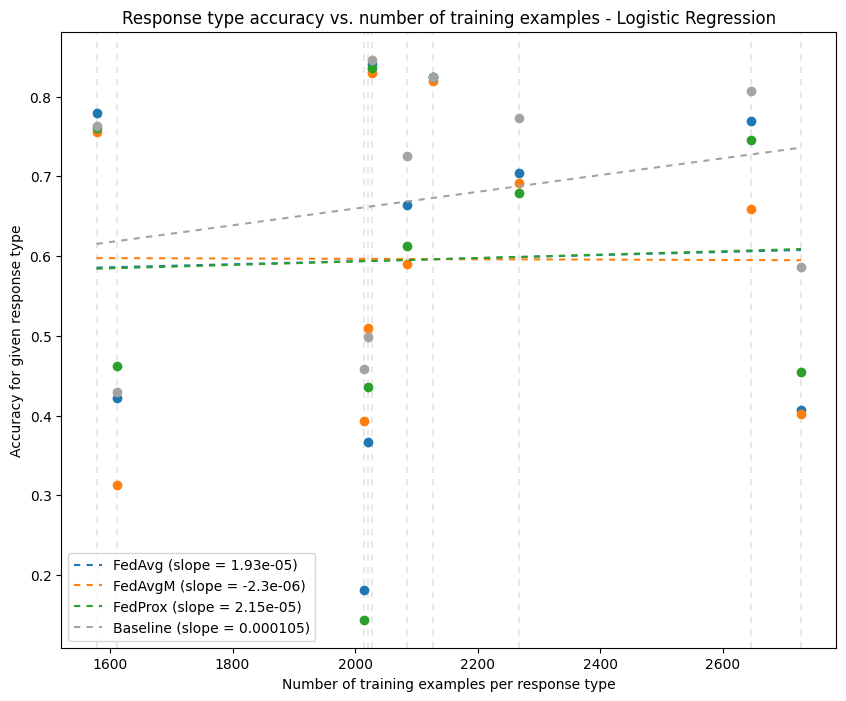

In [13]:
#test out plot of response type accuracy vs # examples of this response type 
#Expect to see lines of positive slope

num_training_examples_per_response_types = np.load('num_training_examples_per_response_types.npy')
method_specific_per_class_accuracies = []
for method in ['FedAvg', 'FedAvgM', 'FedProx', 'Baseline Aggregate Model']:
  all_patients = method_specific_full_patient_dfs[method]
  per_class_accuracies = []
  for i in range(10):
    response_type = all_patients.loc[all_patients.response_type==i]
    per_class_accuracies.append(np.average(np.equal(response_type.treatment.values, response_type.pred_treatment.values)))
  method_specific_per_class_accuracies.append(per_class_accuracies)

method_specific_per_class_accuracies = np.array(method_specific_per_class_accuracies)

fig, ax = plt.subplots(figsize=(10,8))
methods = ['FedAvg', 'FedAvgM', 'FedProx']
for i in range(method_specific_per_class_accuracies.shape[0]-1):
  x1 = num_training_examples_per_response_types.squeeze()
  y1 = method_specific_per_class_accuracies[i].squeeze()
  plt.scatter(x1, y1, zorder=2)
  plt.plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)), label=f'{methods[i]} (slope = {np.round(np.polyfit(x1, y1, 1)[0], 7)})', dashes=(3,3))

x1 = num_training_examples_per_response_types.squeeze()
y1 = method_specific_per_class_accuracies[-1].squeeze()
plt.scatter(x1, y1, zorder=2, color="#a3a3a3")
plt.plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)), label=f'Baseline (slope = {np.round(np.polyfit(x1, y1, 1)[0], 7)})', dashes=(3,3), color="#a3a3a3")


for i in range(10):
  plt.axvline(x = num_training_examples_per_response_types[i], color = '#e8e8e8', dashes = (3, 3), zorder=1)

plt.xlabel("Number of training examples per response type")
plt.ylabel("Accuracy for given response type")
plt.title("Response type accuracy vs. number of training examples - Logistic Regression")
plt.legend()
plt.show()